Files already downloaded and verified


Epoch 1/10: 100%|██████████| 782/782 [02:47<00:00,  4.67batch/s, loss=0.422]


Epoch [1/10], Average Loss: 0.44564488137622016


Epoch 2/10: 100%|██████████| 782/782 [02:48<00:00,  4.65batch/s, loss=0.326]


Epoch [2/10], Average Loss: 0.3845232776592455


Epoch 3/10: 100%|██████████| 782/782 [02:47<00:00,  4.67batch/s, loss=0.387]


Epoch [3/10], Average Loss: 0.37244455645913666


Epoch 4/10: 100%|██████████| 782/782 [02:48<00:00,  4.65batch/s, loss=0.345]


Epoch [4/10], Average Loss: 0.3661921266704569


Epoch 5/10: 100%|██████████| 782/782 [02:46<00:00,  4.68batch/s, loss=0.352]


Epoch [5/10], Average Loss: 0.3629502998974622


Epoch 6/10: 100%|██████████| 782/782 [02:47<00:00,  4.67batch/s, loss=0.375]


Epoch [6/10], Average Loss: 0.36107106933660826


Epoch 7/10: 100%|██████████| 782/782 [02:51<00:00,  4.55batch/s, loss=0.385]


Epoch [7/10], Average Loss: 0.3604914334500232


Epoch 8/10: 100%|██████████| 782/782 [02:57<00:00,  4.41batch/s, loss=0.373]


Epoch [8/10], Average Loss: 0.3597907615668329


Epoch 9/10: 100%|██████████| 782/782 [02:59<00:00,  4.35batch/s, loss=0.357]


Epoch [9/10], Average Loss: 0.3592052508116988


Epoch 10/10: 100%|██████████| 782/782 [02:58<00:00,  4.39batch/s, loss=0.448]
C:\Users\miche\AppData\Local\Temp\ipykernel_32604\3328515520.py:149: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this expe

Epoch [10/10], Average Loss: 0.3589176335526854
Model loaded successfully!


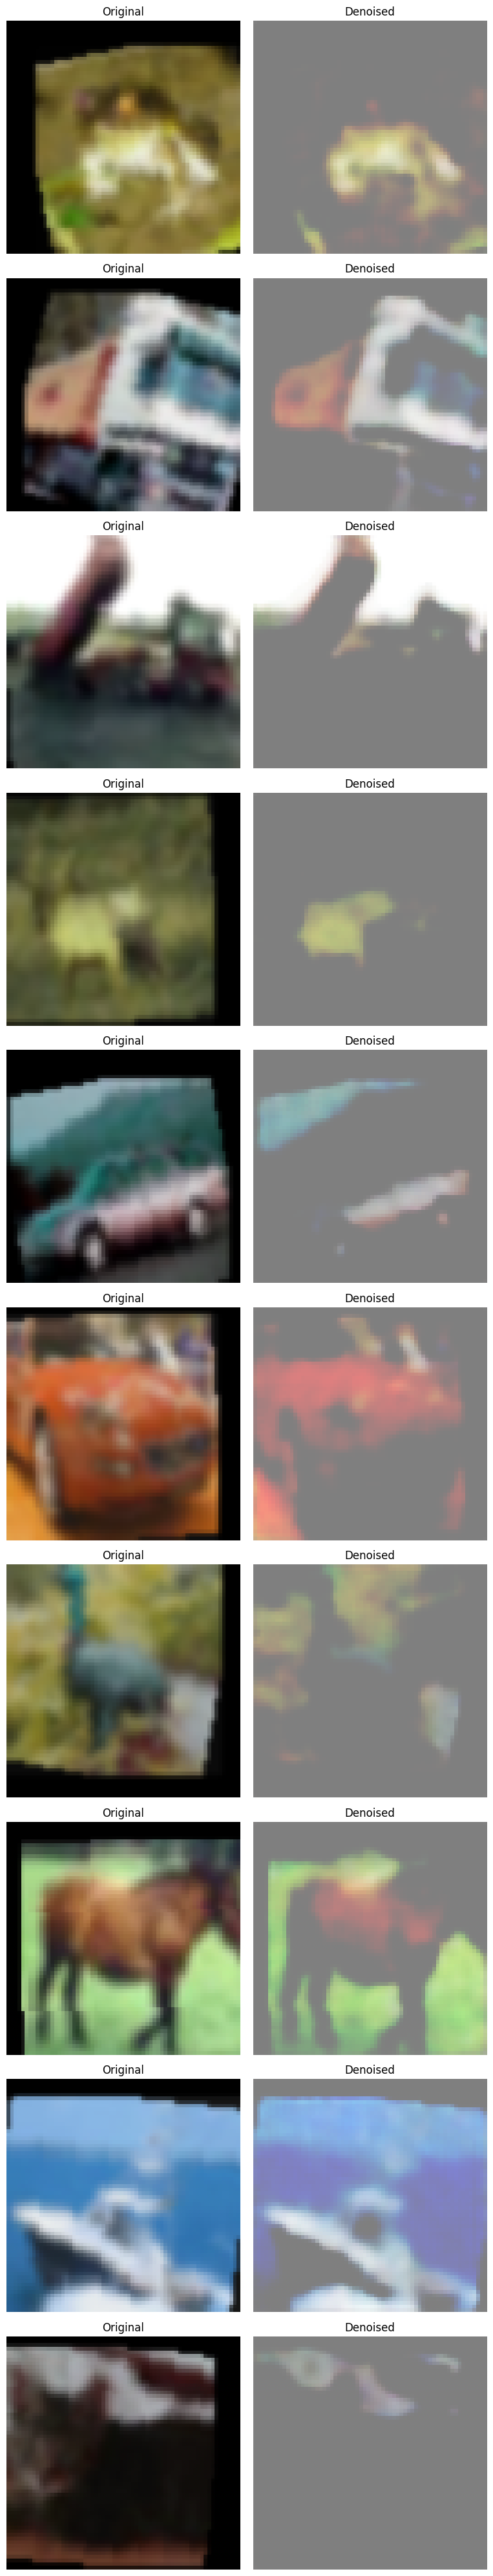

In [13]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from tqdm import tqdm

class UNet(nn.Module):
    def __init__(self):
        super(UNet, self).__init__()

        self.encoder1 = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.Dropout(0.2)
        )
        self.encoder2 = nn.Sequential(
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(128),
            nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(128),
            nn.Dropout(0.2)
        )
        self.encoder3 = nn.Sequential(
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(256),
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(256),
            nn.Dropout(0.2)
        )

        # Decoder
        self.decoder1 = nn.Sequential(
            nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2),
            nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(128),
            nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(128),
            nn.Dropout(0.2)
        )
        self.decoder2 = nn.Sequential(
            nn.ConvTranspose2d(256, 64, kernel_size=2, stride=2),
            nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.Dropout(0.2)
        )
        self.decoder3 = nn.Sequential(
            nn.Conv2d(128, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.Conv2d(64, 3, kernel_size=3, stride=1, padding=1),
            nn.Sigmoid()
        )

    def forward(self, x):
        enc1 = self.encoder1(x)
        enc2 = self.encoder2(enc1)
        enc3 = self.encoder3(enc2)

        dec1 = self.decoder1(enc3)
        dec1 = torch.cat([dec1, enc2], dim=1)  # Skip connection
        dec2 = self.decoder2(dec1)
        dec2 = torch.cat([dec2, enc1], dim=1)  # Skip connection
        out = self.decoder3(dec2)

        return out

def diffuse_images(images, noise_factor=0.2):
    noise = torch.randn_like(images) * noise_factor
    return (images + noise).clamp(0, 1)

transform_train = transforms.Compose([
    transforms.Resize((64, 64), interpolation=transforms.InterpolationMode.BILINEAR),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1), scale=(0.9, 1.1)),
    transforms.GaussianBlur(kernel_size=3, sigma=(0.1, 1.0)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

train_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=4)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = UNet().to(device)
optimizer = optim.Adam(model.parameters(), lr=0.00005)
criterion = nn.L1Loss()
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)

num_epochs = 10
for epoch in range(num_epochs):
    epoch_loss = 0
    with tqdm(train_loader, unit="batch", desc=f"Epoch {epoch+1}/{num_epochs}") as tepoch:
        for batch_idx, (real_images, _) in enumerate(tepoch):
            real_images = real_images.to(device)
            optimizer.zero_grad()

            diffused_images = diffuse_images(real_images)

            predicted_images = model(diffused_images)
            loss = criterion(predicted_images, real_images)

            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()
            tepoch.set_postfix(loss=loss.item())

    scheduler.step()
    print(f"Epoch [{epoch+1}/{num_epochs}], Average Loss: {epoch_loss / len(train_loader)}")

torch.save(model.state_dict(), "unet_denoising.pth")

model = UNet().to(device)
model.load_state_dict(torch.load("unet_denoising.pth"))
model.eval()
print("Model loaded successfully!")

model.eval()
fig, axes = plt.subplots(10, 2, figsize=(8, 40))

with torch.no_grad():
    for i in range(10):
        real_image, _ = train_dataset[i]
        real_image = real_image.unsqueeze(0).to(device)
        diffused_image = diffuse_images(real_image)
        denoised_image = model(diffused_image).squeeze().permute(1, 2, 0).cpu().numpy()

        original_image = (real_image.squeeze().permute(1, 2, 0).cpu().numpy() * 0.5) + 0.5

        axes[i, 0].imshow(original_image)
        axes[i, 0].axis("off")
        axes[i, 0].set_title("Original")

        axes[i, 1].imshow((denoised_image + 1) / 2)
        axes[i, 1].axis("off")
        axes[i, 1].set_title("Denoised")

plt.tight_layout()
plt.show()